# 1. General analysis

## 1.1 Imports and Data Loading

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from scipy import stats
from FlowCytometryTools import FCMeasurement
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statannot import add_stat_annotation


In [69]:
metadata_path = "raw/metagated.csv"
meta = pd.read_csv(metadata_path)
display(meta)

,file_name,sample_id,activated_baseline,patient_id,TP,batch
0,DN1_TP1_A.fcs,DN1_TP1_A,activated,DN1,TP1,1
1,DN1_TP1_B.fcs,DN1_TP1_B,baseline,DN1,TP1,1
2,DN1_TP2_A.fcs,DN1_TP2_A,activated,DN1,TP2,1
3,DN1_TP2_B.fcs,DN1_TP2_B,baseline,DN1,TP2,1
4,DN1_TP4_A.fcs,DN1_TP4_A,activated,DN1,TP4,1
...,...,...,...,...,...,...
78,DN11_TP2_B.fcs,DN11_TP2_B,baseline,DN11,TP2,2
79,DN12_TP1_A.fcs,DN12_TP1_A,activated,DN12,TP1,2
80,DN12_TP1_B.fcs,DN12_TP1_B,baseline,DN12,TP1,2
81,DN12_TP2_A.fcs,DN12_TP2_A,activated,DN12,TP2,2


In [3]:
#directory of fcs files
data_path = "processed/"
files = list(meta.file_name)
time_point = list(meta.TP)
samp = list(meta.sample_id)
#open the first file to retrieve the order of markers
sample = FCMeasurement(ID='Sample', datafile=data_path +files[0])
dat1 = sample.data

genes = dat1.columns
genes = [x.split("_")[1] if len(x.split("_"))>1 else x for x in genes]


In [4]:
# matrix with medians for each marker and each sample
medians_full = np.zeros((len(genes), len(samp)))
# dictionary with medians for each sample and each condition
medians_cond = dict()

# file processing is performed per marker to avoid loading too much data into memory
for i in range(len(genes)):
    print(i)
    gene = genes[i]
    old = 0
    for j in range(len(files)):
        st = time_point[j]
        file = files[j]
        gr = samp[j]
        sample = FCMeasurement(ID='Sample', datafile=data_path +file)
        dat1 = sample.data
        gs = dat1.columns
        genes_new = [x.split("_")[1] if len(x.split("_"))>1 else x for x in gs]
        dat1.columns = genes_new
        new_dat = dat1[[gene]]
        new_dat.columns = ["expression"]
        new_dat["group"] = [gr]*dat1.shape[0]
        new_dat["antibody"] = [gene]*dat1.shape[0]
        new_dat["status"] = [st]*dat1.shape[0]
        new_dat.index = np.arange(old,dat1.shape[0]+old)
        old = dat1.shape[0] + old
        if j == 0:
            all_dat = new_dat.copy()
        else:    
            all_dat = pd.concat([all_dat, new_dat])
    #data transformation
    all_dat.expression = np.arcsinh(all_dat.expression/5)
    if i == 0:
        full = all_dat.copy()
    else:
        full = pd.concat([full, all_dat])
    #medians for healthy and patients
    tp1 = all_dat['expression'][all_dat['status'] == 'TP1']
    tp2 = all_dat['expression'][all_dat['status'] == 'TP2']
    tp3 = all_dat['expression'][all_dat['status'] == 'TP3']
    tp4 = all_dat['expression'][all_dat['status'] == 'TP4']
    medians_cond[gene] = [np.median(tp1), np.median(tp2), np.median(tp3), np.median(tp4)]
    #medians for each sample
    for j in range(len(samp)):
        s = samp[j]
        condition = (all_dat['group'] == s) 
        vals = all_dat['expression'][condition]
        medians_full[i,j] = np.median(vals)
medians_full = pd.DataFrame(medians_full, index = genes, columns = samp)


0


/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

KeyboardInterrupt: 

In [56]:
medians_full.head()

,DN1_TP1_A,DN1_TP1_B,DN1_TP2_A,DN1_TP2_B,DN1_TP4_A,DN1_TP4_B,DN1_TP5_A,DN1_TP5_B,DN2_TP1_A,DN2_TP1_B,...,DN10_TP2_A,DN10_TP2_B,DN11_TP1_A,DN11_TP1_B,DN11_TP2_A,DN11_TP2_B,DN12_TP1_A,DN12_TP1_B,DN12_TP2_A,DN12_TP2_B
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
CD62P,4.616299,0.324437,4.687648,2.668924,4.588343,0.720526,4.926632,1.259724,4.137082,0.105472,...,4.151685,0.037012,3.896505,3.202864,4.118820,0.209610,3.829371,0.723896,3.857642,0.205203
CD69,2.351201,1.692536,2.402996,1.959835,2.361790,1.931959,2.498507,2.059582,1.940715,1.375714,...,2.111101,1.553375,2.052993,1.980633,2.323151,1.808161,1.979390,1.606564,2.029350,1.590758
CD154,0.092747,0.000000,0.098750,0.000000,0.116028,0.000000,0.233244,0.000000,0.134846,0.000000,...,0.043877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD107a,0.134366,0.000000,0.141483,0.000000,0.564413,0.000000,0.895867,0.000000,0.000000,0.000000,...,0.131010,0.000000,0.317646,0.244735,0.141361,0.000000,0.096434,0.000000,0.112634,0.000000


In [57]:
exclude = ["DN1_TP2_B", "DN2_TP2_B", "DN3_TP2_B", "DN4_TP2_B","DN5_TP1_B", "DN9_TP1_B",
           "DN1_TP2_A", "DN2_TP2_A", "DN3_TP2_A", "DN4_TP2_A", "DN5_TP1_A","DN9_TP1_A",
           "DN11_TP1_B"]
medians_full.drop(exclude, inplace=True, axis = 1)

In [58]:
meta = meta[~meta["sample_id"].isin(exclude)]

In [59]:
medians_full.drop(["PEAR", "GPVI"], inplace=True)

In [60]:
markers = list(medians_full.index)
act_m =  ['CD63','CD62P', 'CD154', "CD107a", "PAC1"]

In [62]:
markers = medians_full.index
samples = medians_full.columns
conditions = [list(meta.TP[meta.sample_id == x])[0] for x in samples]
activations = [list(meta.activated_baseline[meta.sample_id == x])[0] for x in samples]
batches = [list(meta.batch[meta.sample_id == x])[0] for x in samples]


last_i = 0
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = activations
    dat1["batch"] = batches
    if i == 0:
        dat = dat1
    else:
        dat = pd.concat([dat,dat1])

In [63]:
dat.tail()

,expression,samples,marker,condition,type,batch
1395,2.234737,DN11_TP2_B,CD47,TP2,baseline,2
1396,2.258480,DN12_TP1_A,CD47,TP1,activated,2
1397,2.127816,DN12_TP1_B,CD47,TP1,baseline,2
1398,2.289363,DN12_TP2_A,CD47,TP2,activated,2
1399,2.119280,DN12_TP2_B,CD47,TP2,baseline,2


### 1.2 Exploration 
#### State markers

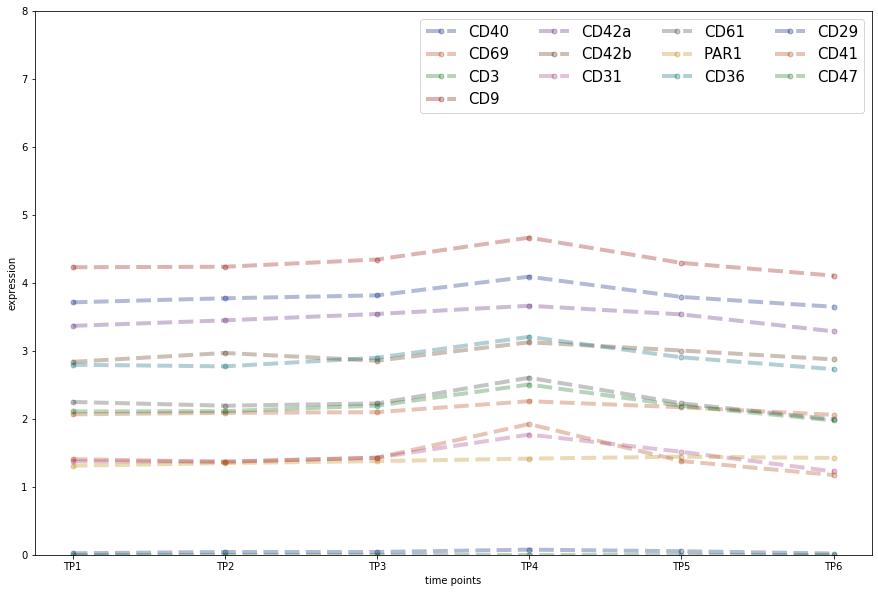

In [39]:
tps = ['TP1', 'TP2','TP3', 'TP4', 'TP5', "TP6"]
na_markers =list(set(markers) -set (act_m) -set(["CD45"]))

palette = sns.color_palette("dark", len(na_markers))

fig, ax = plt.subplots(figsize=(15, 10))
x = [1,2,3,4,5,6]
d= 0.05
count = 0
for m in na_markers:
    pts = [dat[(dat.condition == tp)&(dat.marker == m)& (dat.type == "activated")].expression.values.mean() for tp in tps]
    plt.plot(x,pts, c = palette[count], linestyle = "--", alpha = 0.3, marker = '.', label = m, 
             linewidth=4.0, markersize = 10)
    count = count+1
#     for i in range(len(pts)):
#     if (m == 'PAR1') or (m == 'CD40'):
#         ax.annotate(m, (x[0], pts[0]-d), fontsize=10)
#     else:
        
#         ax.annotate(m, (x[0], pts[0]+d), fontsize=10)

positions = (1, 2, 3, 4,5,6)
plt.xticks(positions, tps)
plt.ylabel("expression")
plt.xlabel("time points")
plt.legend(loc = 1,ncol = 4,fontsize=15)
plt.ylim(0,8)
plt.savefig("plots/timeline_all_activated.pdf",dpi = 350)

plt.show()

#### Platelets activation markers (baseline)

/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.


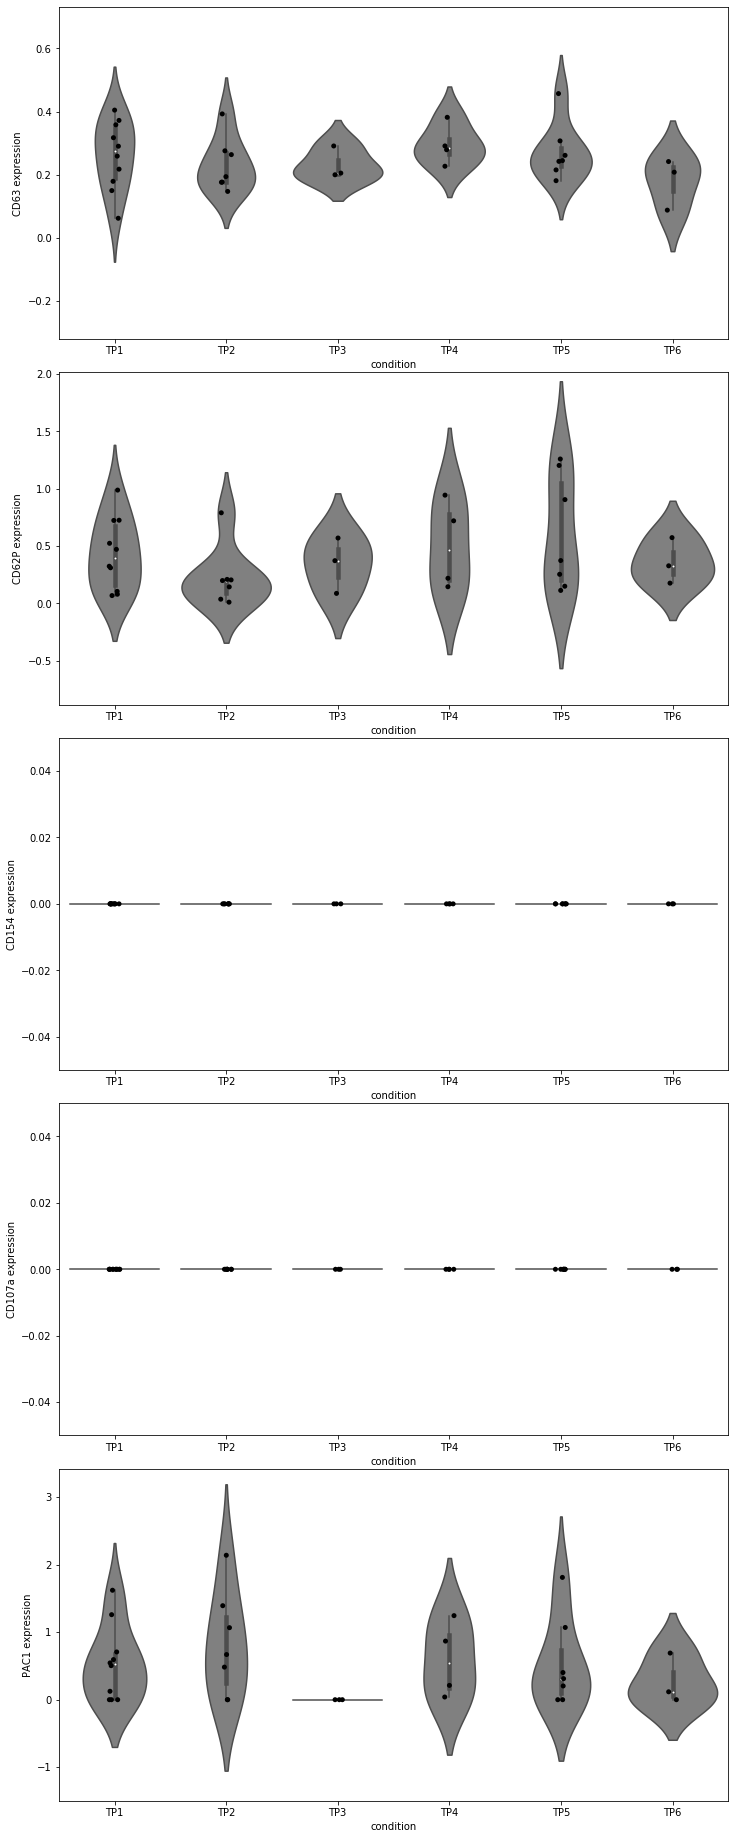

In [79]:
tps = ['TP1', 'TP2', 'TP3', 'TP4', 'TP5', "TP6"]
fig = plt.figure(figsize=(12, 33))
gs = gridspec.GridSpec(len(act_m), 1, hspace=0.1, wspace=0.3)

x = [1, 2, 3, 4, 5, 6]
d = 0.05
count = 0
for m in act_m:
    d = dat[(dat.marker == m)&(dat.type == "baseline")]
    ax = plt.subplot(gs[count])

    bp = sns.violinplot(ax=ax, data=d, x="condition",
                     y="expression", order=tps, palette=["grey"])


    sns.stripplot(ax=ax, data=d, x="condition", y="expression",
                  order=tps, jitter=0.05, palette=["black"])

    count = count+1
    ax.set(ylabel=f'{m} expression')
    ax.set(ylim = (-0.7*d['expression'].max(),1.6*d['expression'].max()))




# plt.savefig("plots/vac_baseline.pdf", dpi=350)

plt.show()

#### Platelets activation markers (activated)

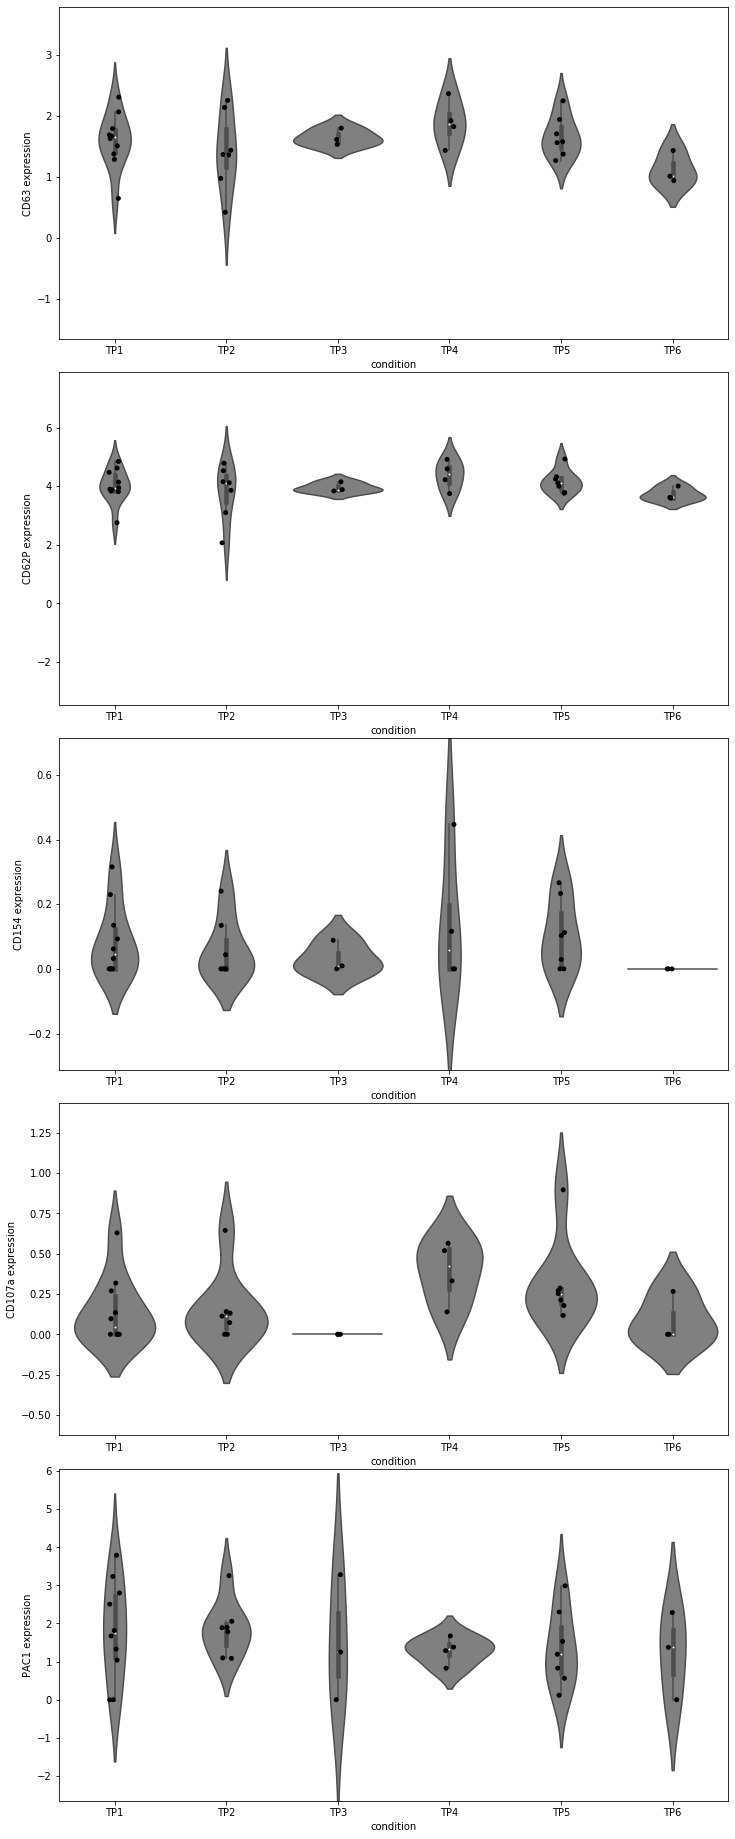

In [78]:
tps = ['TP1', 'TP2', 'TP3', 'TP4', 'TP5', "TP6"]
fig = plt.figure(figsize=(12, 33))
gs = gridspec.GridSpec(len(act_m), 1, hspace=0.1, wspace=0.3)

x = [1, 2, 3, 4, 5, 6]
d = 0.05
count = 0
for m in act_m:
    d = dat[(dat.marker == m)&(dat.type == "activated")]
    ax = plt.subplot(gs[count])

    bp = sns.violinplot(ax=ax, data=d, x="condition",
                     y="expression", order=tps, palette=["grey"])


    sns.stripplot(ax=ax, data=d, x="condition", y="expression",
                  order=tps, jitter=0.05, palette=["black"])


    count = count+1
    ax.set(ylabel=f'{m} expression')
    ax.set(ylim = (-0.7*d['expression'].max(),1.6*d['expression'].max()))




plt.savefig("plots/vac_activated.pdf", dpi=350)

plt.show()

### 1.3 Statistical analysis
#### Mann-Whitney-U test

In [30]:
results = []
for m in markers:
    d = dat[(dat.marker == m)& (dat.type == "baseline")]
    tp1_b = d[d.condition == "TP1"].expression
    tp5 = d[d.condition == "TP5"].expression
    tp2 = d[d.condition == "TP2"].expression
    m1 = tp1_b.median()
    m2 = tp2.median()
    m5 = tp5.median()
    m3 = d[d.condition == "TP3"].expression.median()
    m4 = d[d.condition == "TP4"].expression.median()
    m6 = d[d.condition == "TP6"].expression.median()


    
    if m1!=m2:
        _,pv2 = stats.mannwhitneyu(tp1_b,tp2, alternative = "less")
    else:
        pv2 = "-"
    if m1!=m5:
        _,pv5 = stats.mannwhitneyu(tp1_b,tp2, alternative = "less")
    else:
        pv5 = "-"
    
    results.append([m,"baseline",pv2,pv5,m1,m2,m3,m4,m5,m6])
    d = dat[(dat.marker == m)& (dat.type == "activated")]
    tp1_b = d[d.condition == "TP1"].expression
    tp5 = d[d.condition == "TP5"].expression
    tp2 = d[d.condition == "TP2"].expression
    m1 = tp1_b.median()
    m2 = tp2.median()
    m5 = tp5.median()
    m3 = d[d.condition == "TP3"].expression.median()
    m4 = d[d.condition == "TP4"].expression.median()
    m6 = d[d.condition == "TP6"].expression.median()
    if m1!=m2:
        _,pv2 = stats.mannwhitneyu(tp1_b,tp2, alternative = "less")
    else:
        pv2 = "-"
    if m1!=m5:
        _,pv5 = stats.mannwhitneyu(tp1_b,tp2, alternative = "less")
    else:
        pv5 = "-"
    results.append([m,"activated",pv2,pv5,m1,m2,m3,m4,m5,m6])


In [31]:
res = pd.DataFrame(results, columns=[
    "marker", "baseline/activated", "TP1 to TP2 pv", "TP1 to TP5_b pv",
    "TP1 median", "TP2 median", "TP3 median","TP4 median","TP5 median","TP6 median"])
res.to_csv("plots/p_values.csv")
res

,marker,baseline/activated,TP1 to TP2 pv,TP1 to TP5_b pv,TP1 median,TP2 median,TP3 median,TP4 median,TP5 median,TP6 median
0,CD62P,baseline,0.921474,0.921474,0.398035,0.199552,0.373037,0.469997,0.373939,0.328180
1,CD62P,activated,0.558191,0.558191,3.920430,4.118820,3.883174,4.404410,4.108826,3.616093
2,CD69,baseline,0.519459,0.519459,1.648635,1.620883,1.765316,1.768341,1.721850,1.646236
3,CD69,activated,0.262931,0.262931,1.977199,2.111101,2.100578,2.299749,2.176722,2.099042
4,CD154,baseline,-,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,CD154,activated,0.748489,0.748489,0.046670,0.000000,0.009140,0.058014,0.103074,0.000000
6,CD3,baseline,-,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,CD3,activated,-,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,CD107a,baseline,-,-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,CD107a,activated,0.361697,0.361697,0.048217,0.112634,0.000000,0.425142,0.252359,0.000000


#### Kruskal-Wallis test

In [35]:
results = []


for m in markers:
    d = dat[(dat.marker == m)& (dat.type == "baseline")]
    tp1 = d[d.condition == "TP1"].expression.values
    tp2 = d[d.condition == "TP2"].expression.values
    tp5 = d[d.condition == "TP5"].expression.values
    try:
        t = stats.kruskal(tp1, tp2, tp5)[1]
    except:
        t = 1
    results.append([m,"baseline",t])

    d = dat[(dat.marker == m)& (dat.type == "activated")]
    tp1 = d[d.condition == "TP1"].expression.values
    tp2 = d[d.condition == "TP2"].expression.values
    tp5 = d[d.condition == "TP5"].expression.values
    try:
        t = stats.kruskal(tp1, tp2, tp5)[1]
    except:
        t = 1
    results.append([m,"activated",t])


In [37]:
res = pd.DataFrame(results, columns=[
    "marker", "baseline/activated", "p-value"])
res.to_csv("plots/p_values_one.csv")

#### Slopes comparison

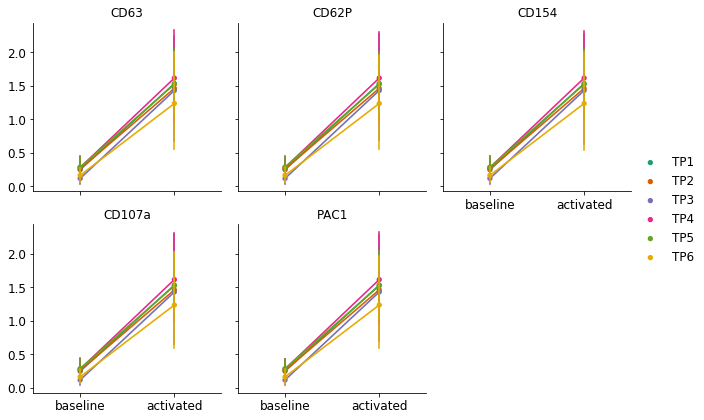

In [331]:
g = sns.FacetGrid(data=dat[dat["marker"].isin(act_m)],
                  col="marker", col_wrap=3, col_order=act_m)
with plt.rc_context({'lines.linewidth': 0.9}):

    g.map(sns.pointplot, x="type", y="expression", hue="condition", order=[
          "baseline", "activated"], data=dat[dat["marker"].isin(act_m)], palette = "Dark2",
         hue_order = ["TP1", "TP2", "TP3", "TP4", "TP5", "TP6"])
g.add_legend()
axes = g.axes.flatten()
[axes[i].set_title(act_m[i]) for i in range(len(act_m))]
g.savefig("plots/slopes_compare.pdf")


# 2. Comparison to COVID19 data
## 2.1 Data loading and aggregation

In [80]:
meta_cov = pd.read_excel(
    "../sars_cov_platelets/data/meta_11vs8.xlsx", sheet_name="Sheet1")
meta_cov.head()

,file_name,sample_id,condition,patient_id
0,CVD001B_platelets.fcs,CVD001B,healthy,CVD001
1,CVD002B_platelets.fcs,CVD002B,patient,CVD002
2,CVD003B_platelets.fcs,CVD003B,healthy,CVD003
3,CVD005B_platelets.fcs,CVD005B,patient,CVD005
4,CVD006B_platelets.fcs,CVD006B,healthy,CVD006


In [81]:
data_path = "../sars_cov_platelets/data/files_na/"

files = list(meta_cov.file_name)
status = list(meta_cov.condition)
samp = list(meta_cov.sample_id)
# open the first file to retrieve the order of markers
sample = FCMeasurement(ID='Sample', datafile=data_path + files[0])
dat1 = sample.data
genes = dat1.columns
genes = [x.split("_")[1] for x in genes]

# matrix with medians for each marker and each sample
medians_full_cov = np.zeros((len(markers), len(samp)))

In [82]:
for i in range(len(markers)):
    print(i)
    gene = markers[i]
    old = 0
    for j in range(len(files)):
        st = status[j]
        file = files[j]
        gr = samp[j]
        sample = FCMeasurement(ID='Sample', datafile=data_path + file)
        dat1 = sample.data
        gs = dat1.columns
        genes_new = [x.split("_")[1] for x in gs]
        dat1.columns = genes_new
        new_dat = dat1[[gene]]
        new_dat.columns = ["expression"]
        new_dat["group"] = [gr]*dat1.shape[0]
        new_dat["antibody"] = [gene]*dat1.shape[0]
        new_dat["status"] = [st]*dat1.shape[0]
        new_dat.index = np.arange(old, dat1.shape[0]+old)
        old = dat1.shape[0] + old
        if j == 0:
            all_dat = new_dat.copy()
        else:
            all_dat = pd.concat([all_dat, new_dat])
    # data transformation
    all_dat.expression = np.arcsinh(all_dat.expression/5)
    # medians for each sample
    for j in range(len(samp)):
        s = samp[j]
        condition = (all_dat['group'] == s)
        vals = all_dat['expression'][condition]
        medians_full_cov[i, j] = np.median(vals)
medians_full_cov = pd.DataFrame(medians_full_cov, index=markers, columns=samp)

0


/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [83]:
meta_cov_activated = pd.read_excel(
    "../sars_cov_platelets/data/meta_11vs8_activated.xlsx", sheet_name="Sheet1")
meta_cov_activated.head()

,file_name,sample_id,condition,patient_id
0,CVD001A_platelets.fcs,CVD001A,healthy,CVD001
1,CVD002A_platelets.fcs,CVD002A,patient,CVD002
2,CVD003A_platelets.fcs,CVD003A,healthy,CVD003
3,CVD005A_platelets.fcs,CVD005A,patient,CVD005
4,CVD006A_platelets.fcs,CVD006A,healthy,CVD006


In [85]:
data_path = "../sars_cov_platelets/data/files_activated/"

files = list(meta_cov_activated.file_name)
status = list(meta_cov_activated.condition)
samp = list(meta_cov_activated.sample_id)
# open the first file to retrieve the order of markers
sample = FCMeasurement(ID='Sample', datafile=data_path + files[0])
dat1 = sample.data
genes = dat1.columns
genes = [x.split("_")[1] for x in genes]

# matrix with medians for each marker and each sample
medians_full_cov_activated = np.zeros((len(markers), len(samp)))

In [86]:
for i in range(len(markers)):
    print(i)
    gene = markers[i]
    old = 0
    for j in range(len(files)):
        st = status[j]
        file = files[j]
        gr = samp[j]
        sample = FCMeasurement(ID='Sample', datafile=data_path + file)
        dat1 = sample.data
        gs = dat1.columns
        genes_new = [x.split("_")[1] for x in gs]
        dat1.columns = genes_new
        new_dat = dat1[[gene]]
        new_dat.columns = ["expression"]
        new_dat["group"] = [gr]*dat1.shape[0]
        new_dat["antibody"] = [gene]*dat1.shape[0]
        new_dat["status"] = [st]*dat1.shape[0]
        new_dat.index = np.arange(old, dat1.shape[0]+old)
        old = dat1.shape[0] + old
        if j == 0:
            all_dat = new_dat.copy()
        else:
            all_dat = pd.concat([all_dat, new_dat])
    # data transformation
    all_dat.expression = np.arcsinh(all_dat.expression/5)
    # medians for each sample
    for j in range(len(samp)):
        s = samp[j]
        condition = (all_dat['group'] == s)
        vals = all_dat['expression'][condition]
        medians_full_cov_activated[i, j] = np.median(vals)
medians_full_cov_activated = pd.DataFrame(medians_full_cov_activated, index=markers, columns=samp)

0


/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/home/users/olgala/.conda/envs/tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [90]:
meta_cov["activated_baseline"] = ["baseline"]*meta_cov.shape[0]
meta_cov_activated["activated_baseline"] = ["activated"]*meta_cov_activated.shape[0]
meta_cov = pd.concat([meta_cov,meta_cov_activated])

In [94]:
medians_full_cov = pd.concat([medians_full_cov,medians_full_cov_activated], axis = 1)

In [98]:
samples = medians_full_cov.columns
conditions = [list(meta_cov.condition[meta_cov.sample_id == x])[0]
              for x in samples]
types = [list(meta_cov.activated_baseline[meta_cov.sample_id == x])[0]
              for x in samples]
last_i = 0
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_cov.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index = np.arange(last_i, dat1.shape[0]+last_i)
    last_i = dat1.shape[0] + last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = types


    dat = pd.concat([dat, dat1])

In [116]:
dat = dat.replace("patient","COVID19")


In [139]:
dat.head()

,expression,samples,marker,condition,type,batch
0,4.616299,DN1_TP1_A,CD62P,TP1,activated,1.0
1,0.324437,DN1_TP1_B,CD62P,TP1,baseline,1.0
2,4.588343,DN1_TP4_A,CD62P,TP4,activated,1.0
3,0.720526,DN1_TP4_B,CD62P,TP4,baseline,1.0
4,4.926632,DN1_TP5_A,CD62P,TP5,activated,1.0


## 2.2. Comparison to COVID19 for the baseline samples

In [172]:
#for storage of fold changes
dat_norm_baseline = dat.copy()

In [144]:
tps = ['TP1', 'TP2', 'TP5', "healthy", "COVID19"]
for m in act_m[:2]:
    ref_TP = dat[(dat.condition == "TP1") & (dat.marker == m)
                 & (dat.type == "baseline")].expression.mean()
    ref_cvd = dat[(dat.condition == "healthy") & (dat.marker == m)
                  & (dat.type == "baseline")].expression.mean()

    for tp in tps:
        if tp[:-1] == "TP":
            ref = ref_TP
        else:
            ref = ref_cvd

        correct = dat[(dat.condition == tp) & (dat.marker == m)
                      & (dat.type == "baseline")]["expression"].values
        correct = correct/ref

        dat_norm_baseline.loc[(dat_norm_baseline.condition == tp) & (
            dat_norm_baseline.marker == m) & (dat.type == "baseline"), "expression"] = correct

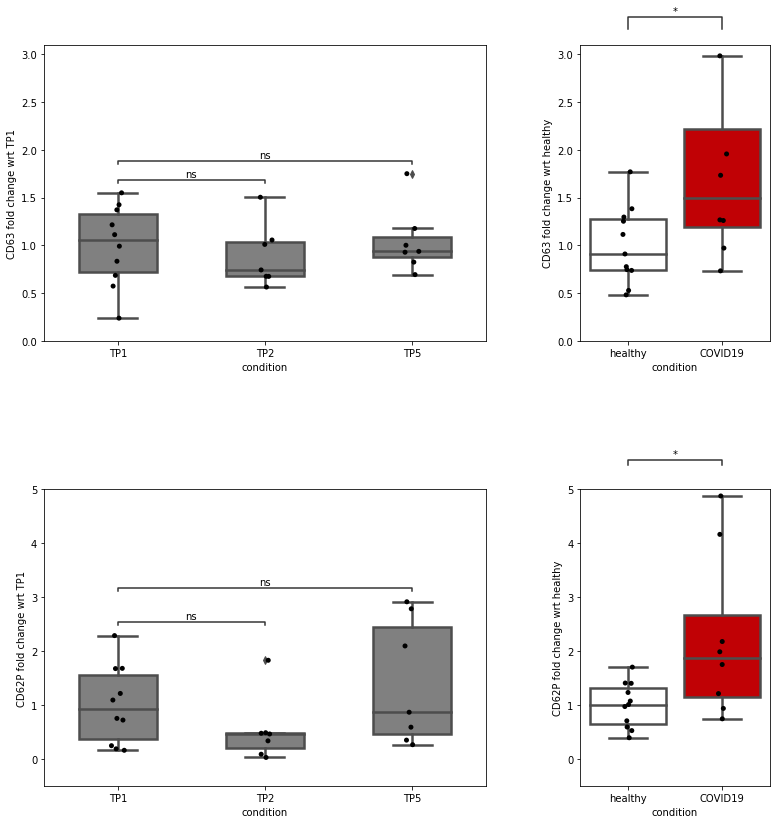

In [152]:
ylims = [(0, 3.1), (-0.5, 5)]
offsets = [[-100, 0.5], [-0.51, 0.06]]

hights = dict({'CD63': (.2, 0.15, 0.3), 'CD62P': (.2, 0.2, 0.3),
              'CD154': (.001, .001, 0.0015), 'CD107a': (.2, .05, .1)})
tps = ['TP1', 'TP2', 'TP5', "healthy", "COVID19"]
fig = plt.figure(figsize=(13, 30))

gs = gridspec.GridSpec(4, 2, hspace=0.5,
                       wspace=0.3, width_ratios=[0.7, 0.3])

count = 0
for m in act_m[:2]:
    d = dat_norm_baseline[(dat_norm_baseline.marker == m) & (
        dat_norm_baseline.condition.isin(tps[:-2])) & (dat_norm_baseline.type == "baseline")]
    ax = plt.subplot(gs[count, 0])

    bp = sns.boxplot(ax=ax, data=d, x="condition",
                     y="expression", order=tps[:-2], palette=["grey"], linewidth=2.5, width=0.53)

    sns.stripplot(ax=ax, data=d, x="condition", y="expression",
                  order=tps[:-2], jitter=0.05, palette=["black"])

    add_stat_annotation(ax=ax, data=d, x="condition", y="expression", order=tps[:-2],
                        box_pairs=[("TP1", "TP2"), ("TP1", "TP5")],
                        test="Mann-Whitney-ls", text_format='star', verbose=0, line_offset=offsets[0][count],
                        comparisons_correction=None)

    ax.set(ylabel=f'{m} fold change wrt TP1')
    ax.set(ylim=ylims[count])

    d = dat_norm_baseline[(dat_norm_baseline.marker == m) & (
        dat_norm_baseline.condition.isin(tps[-2:])) & (dat_norm_baseline.type == "baseline")]

    ax = plt.subplot(gs[count, 1])

    bp = sns.boxplot(ax=ax, data=d, x="condition",
                     y="expression", order=tps[-2:], palette=["grey"], linewidth=2.5,  width=0.8)
    mybox = bp.artists[-1]
    mybox.set_facecolor('#C00105')

    mybox = bp.artists[-2]
    mybox.set_facecolor("w")

    sns.stripplot(ax=ax, data=d, x="condition", y="expression",
                  order=tps[-2:], jitter=0.05, palette=["black"])

    add_stat_annotation(ax=ax, data=d, x="condition", y="expression", order=tps[-2:],
                        box_pairs=[("healthy", "COVID19")],
                        test="Mann-Whitney-ls", text_format='star', loc='outside', verbose=0, line_offset=offsets[1][count],
                        comparisons_correction=None)
#                         stats_params={"alternative": "less"})

    ax.set(ylabel=f'{m} fold change wrt healthy')

    ax.set(ylim=ylims[count])

    count = count+1
#plt.savefig("plots/vac_vs_covid_baseline_sep.pdf", dpi=350)

plt.show()

## 2.2. Comparison to COVID19 for the activated samples

In [171]:
#for storage of fold changes
dat_norm_activated = dat.copy()

In [163]:
tps = ['TP1', 'TP2', 'TP5', "healthy", "COVID19"]
for m in act_m[:2]:
    ref_TP = dat[(dat.condition == "TP1") & (dat.marker == m)
                 & (dat.type == "activated")].expression.mean()
    ref_cvd = dat[(dat.condition == "healthy") & (dat.marker == m)
                  & (dat.type == "activated")].expression.mean()

    for tp in tps:
        if tp[:-1] == "TP":
            ref = ref_TP
        else:
            ref = ref_cvd

        correct = dat[(dat.condition == tp) & (dat.marker == m)
                      & (dat.type == "activated")]["expression"].values
        correct = correct/ref

        dat_norm_activated.loc[(dat_norm_activated.condition == tp) & (
            dat_norm_activated.marker == m) & (dat.type == "activated"), "expression"] = correct

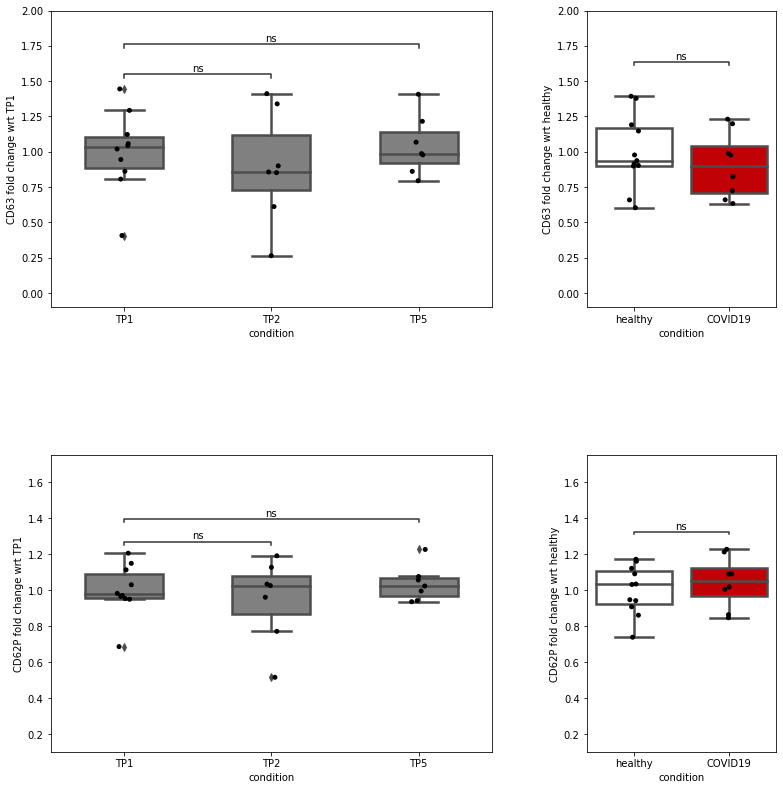

In [170]:
ylims = [(-0.1,2), (0.1,1.75)]
offsets = [[0.1,0.1],[0.2,0.1]]

hights = dict({'CD63': (.2, 0.15, 0.3), 'CD62P': (.2, 0.2, 0.3),
              'CD154': (.001, .001, 0.0015), 'CD107a': (.2, .05, .1)})

tps = ['TP1', 'TP2', 'TP5', "healthy", "COVID19"]
fig = plt.figure(figsize=(13, 30))

gs = gridspec.GridSpec(4, 2, hspace=0.5,
                       wspace=0.3, width_ratios=[0.7, 0.3])

count = 0
for m in act_m[:2]:
    d = dat_norm_activated[(dat_norm_activated.marker == m) & (
        dat_norm_activated.condition.isin(tps[:-2])) & (dat_norm_activated.type == "activated")]
    ax = plt.subplot(gs[count, 0])

    bp = sns.boxplot(ax=ax, data=d, x="condition",
                     y="expression", order=tps[:-2], palette=["grey"], linewidth=2.5, width=0.53)

    sns.stripplot(ax=ax, data=d, x="condition", y="expression",
                  order=tps[:-2], jitter=0.05, palette=["black"])

    add_stat_annotation(ax=ax, data=d, x="condition", y="expression", order=tps[:-2],
                        box_pairs=[("TP1", "TP2"), ("TP1", "TP5")],
                        test="Mann-Whitney-ls", text_format='star', verbose=0, line_offset=offsets[0][count],
                        comparisons_correction=None)

    ax.set(ylabel=f'{m} fold change wrt TP1')
    ax.set(ylim=ylims[count])

    d = dat_norm_activated[(dat_norm_activated.marker == m) & (
        dat_norm_activated.condition.isin(tps[-2:])) & (dat_norm_activated.type == "activated")]

    ax = plt.subplot(gs[count, 1])

    bp = sns.boxplot(ax=ax, data=d, x="condition",
                     y="expression", order=tps[-2:], palette=["grey"], linewidth=2.5,  width=0.8)
    mybox = bp.artists[-1]
    mybox.set_facecolor('#C00105')

    mybox = bp.artists[-2]
    mybox.set_facecolor("w")

    sns.stripplot(ax=ax, data=d, x="condition", y="expression",
                  order=tps[-2:], jitter=0.05, palette=["black"])

    add_stat_annotation(ax=ax, data=d, x="condition", y="expression", order=tps[-2:],
                        box_pairs=[("healthy", "COVID19")],
                        test="Mann-Whitney-ls", text_format='star', loc='outside', verbose=0, line_offset=offsets[1][count],
                        comparisons_correction=None)
#                         stats_params={"alternative": "less"})

    ax.set(ylabel=f'{m} fold change wrt healthy')

    ax.set(ylim=ylims[count])

    count = count+1
plt.savefig("plots/vac_vs_covid_activated_sep.pdf", dpi=350)

plt.show()